In [6]:
%reset -f

In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import os

import torch
import torch.nn as nn

## Dataset

In [8]:
os.getcwd()

'/Users/armand/Documents/Projects/05_TimeSeries/06_Jena_Weather/weather_forecasting/notebook'

In [9]:
df = pd.read_csv("../src/data/jena_climate_2009_2016.csv")

In [10]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


This tutorial will just deal with hourly predictions, so start by sub-sampling the data from 10-minute intervals to one-hour intervals:

In [11]:
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]
#df.pop('Date Time') returns Date Time values and removes the Date Time column itself
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [12]:
date_time.head()

5    2009-01-01 01:00:00
11   2009-01-01 02:00:00
17   2009-01-01 03:00:00
23   2009-01-01 04:00:00
29   2009-01-01 05:00:00
Name: Date Time, dtype: datetime64[ns]

In [13]:
#data frame without date_time
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


### EDA

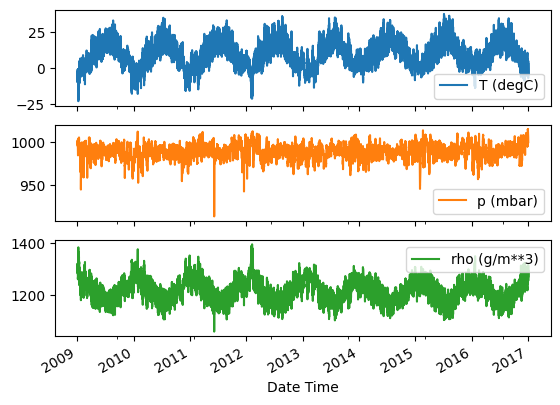

In [14]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']

plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

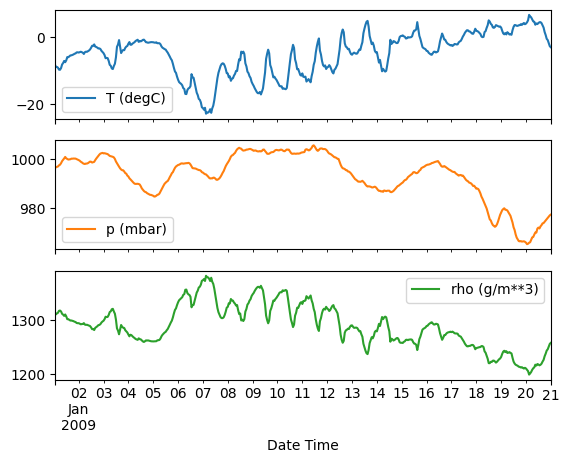

In [15]:
plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### inspect & cleanup

In [16]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


## Feature Engineering

### Wind
The last column of the data, wd (deg)—gives the wind direction in units of degrees. Angles do not make good model inputs: 360° and 0° should be close to each other and wrap around smoothly. Direction shouldn't matter if the wind is not blowing.

Right now the distribution of wind data looks like this:

<Axes: xlabel='wd (deg)', ylabel='Count'>

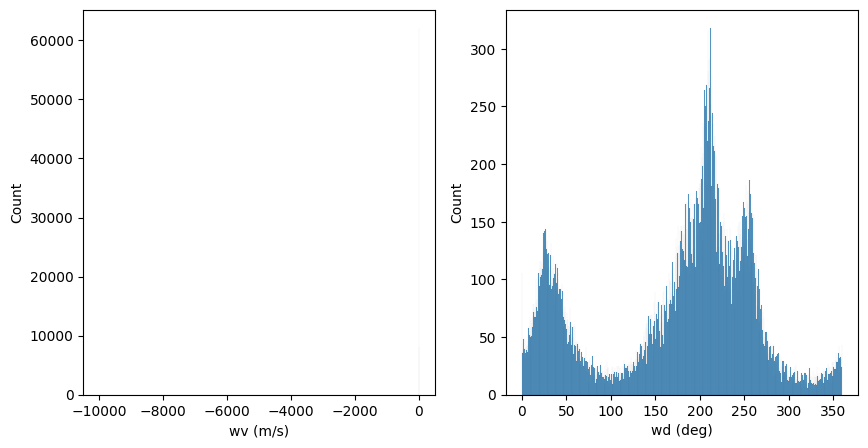

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(data=df, x='wv (m/s)', bins=1000, ax=ax[0])
sns.histplot(data=df, x='wd (deg)', bins=1000, ax=ax[1])


Text(0, 0.5, 'Wind Velocity [m/s]')

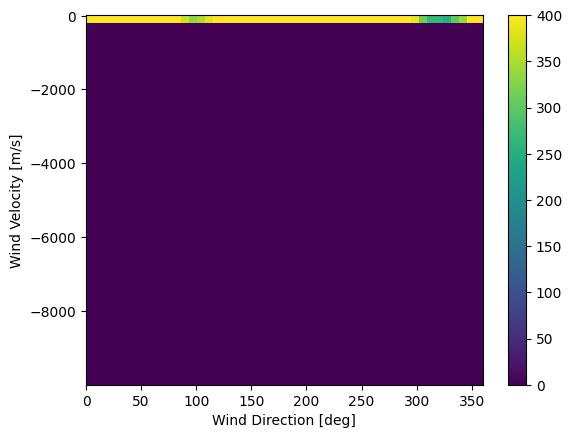

In [18]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind vector:

In [19]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

<Axes: ylabel='Wy'>

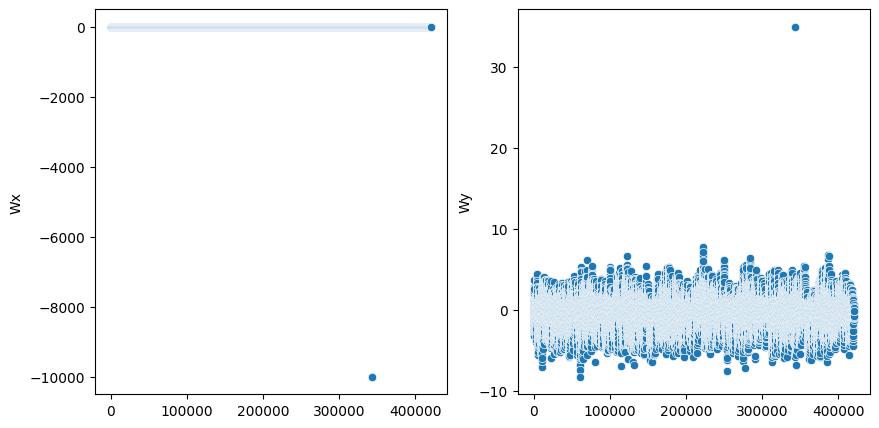

In [20]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.scatterplot(df['Wx'], ax = ax[0])
sns.scatterplot(df['Wy'], ax = ax[1])

(-9998.939082670246, 8.24469928549079, -8.27438540335515, 34.90302350082238)

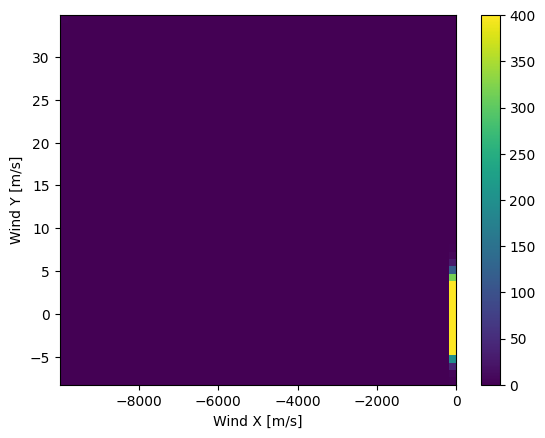

In [21]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [22]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.600000,984.200000,989.570000,994.720000,1015.290000
T (degC),70091.0,9.450482,8.423384,-22.760000,3.350000,9.410000,15.480000,37.280000
Tpot (K),70091.0,283.493086,8.504424,250.850000,277.440000,283.460000,289.530000,311.210000
Tdew (degC),70091.0,4.956471,6.730081,-24.800000,0.240000,5.210000,10.080000,23.060000
rh (%),70091.0,76.009788,16.474920,13.880000,65.210000,79.300000,89.400000,100.000000
VPmax (mbar),70091.0,13.576576,7.739883,0.970000,7.770000,11.820000,17.610000,63.770000
VPact (mbar),70091.0,9.533968,4.183658,0.810000,6.220000,8.860000,12.360000,28.250000
VPdef (mbar),70091.0,4.042536,4.898549,0.000000,0.870000,2.190000,5.300000,46.010000
sh (g/kg),70091.0,6.022560,2.655812,0.510000,3.920000,5.590000,7.800000,18.070000
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.810000,6.290000,8.960000,12.490000,28.740000


### Time
Similarly, the Date Time column is very useful, but not in this string form. Start by converting it to seconds:

In [23]:
#in seconds
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [24]:
timestamp_s

5         1.230772e+09
11        1.230775e+09
17        1.230779e+09
23        1.230782e+09
29        1.230786e+09
              ...     
420521    1.483211e+09
420527    1.483215e+09
420533    1.483219e+09
420539    1.483222e+09
420545    1.483226e+09
Name: Date Time, Length: 70091, dtype: float64

Similar to the wind direction, the time in seconds is not a useful model input. Being weather data, it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

You can get usable signals by using sine and cosine transforms to clear "Time of day" and "Time of year" signals:

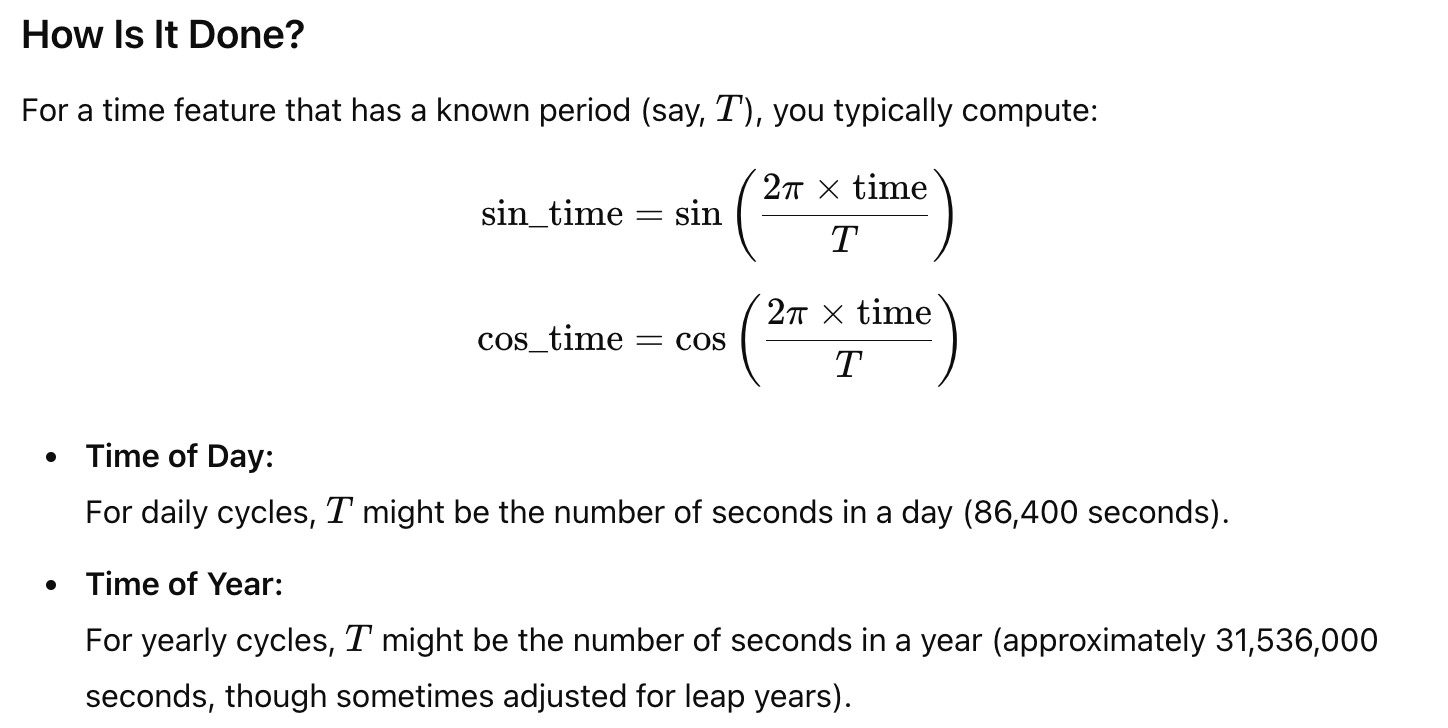


In [25]:
day = 24*60*60
year = (365.2425) * day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [26]:
#df.describe().transpose()

Text(0.5, 1.0, 'Time of day signal')

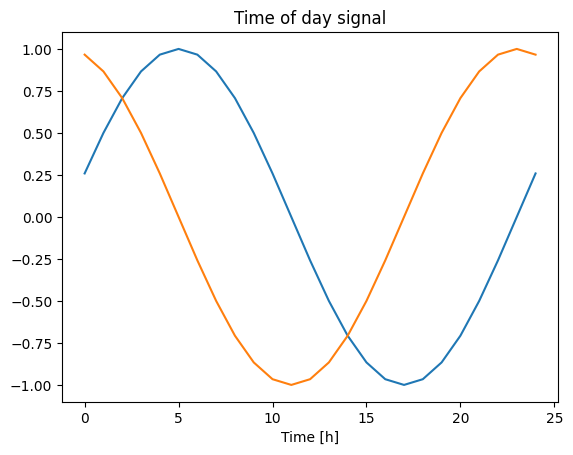

In [27]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0.5, 1.0, 'Time of Year signal')

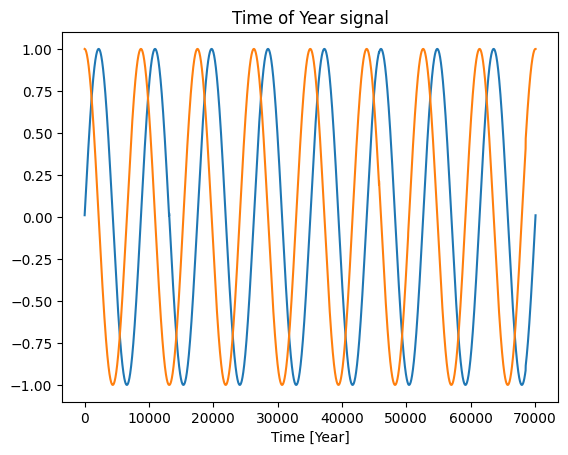

In [28]:
plt.plot(np.array(df['Year sin']))
plt.plot(np.array(df['Year cos']))
plt.xlabel('Time [Year]')
plt.title('Time of Year signal')

In [30]:
df.columns

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'Wx', 'Wy', 'max Wx', 'max Wy',
       'Day sin', 'Day cos', 'Year sin', 'Year cos'],
      dtype='object')

**Frequency Features:**
When we talk about "frequency features," we're referring to the patterns in data that repeat at regular intervals. For weather data, two important cycles are daily (1 cycle per day) and yearly (1 cycle per year).

**Prior Knowledge vs. Discovery:**
In some cases, like weather forecasting, you already know that certain cycles (daily and yearly) are important. That’s why you might directly create features using sine and cosine transforms for those cycles.
However, if you’re not sure which cycles or frequencies are significant in your data, you can use the ***Fast Fourier Transform (FFT)*** to analyze the data and find out.

> ***torch.fft.rfft***
This function computes the real-valued FFT of your temperature data (assuming it's a real-valued signal). **The FFT converts your time-domain data (temperature over time) into frequency-domain data (showing the contribution of different frequencies).**

In [151]:
# Assuming your temperature data is a 1D tensor
temperature = torch.tensor(df['T (degC)'].values, dtype=torch.float32)

# Compute the real FFT
fft = torch.fft.rfft(temperature)

In [152]:
#This creates an array of indices corresponding to the FFT output bins.
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset


**What Do the Peaks Mean?**

***Peaks at ~1/year and ~1/day:***
The visible peaks in the FFT output indicate that your temperature data has strong periodic patterns at these frequencies. This confirms the assumption that weather data is strongly influenced by daily and seasonal (yearly) cycles.

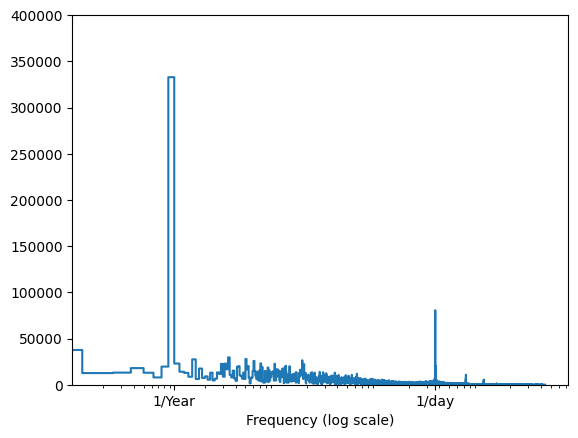

In [153]:
plt.step(f_per_year, np.abs(fft))
#Log Scale for Frequency
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

**Importance of this analysis**

This approach is used to verify that your data indeed has significant cycles (daily and yearly) by looking at the frequency spectrum. The principle behind using sine and cosine transformations is to encode the cyclical nature of time with the correct period.

If you already know these are the important cycles, you can directly encode them using sine and cosine features. For example, here we encoded Day and Year with Cosine / Sine functions
If you're uncertain, using the FFT helps you identify which frequencies (cycles) are significant in your data. Then you can decide how to incorporate this information into your model.

For example, if your data showed a different significant cycle—say, a quarterly cycle—you would adjust the period accordingly. For example, if a quarter is roughly 3 months, you would compute the number of seconds (or days) in a quarter and use that in your transformation. 

## Processing

In [33]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
df_train = df[0:int(n*0.7)]
df_val = df[int(n*0.7):int(n*0.9)]
df_test = df[int(n*0.9):]

In [34]:
num_features = df.shape[1]
num_features

19

### Normalization

Here Temperautre (target) seems to be stationary so this normalization is enough

In [164]:
train_mean = df_train.mean()
train_std = df_train.std()

df_train = (df_train - train_mean) / train_std
df_val = (df_val - train_mean) / train_std
df_test = (df_test - train_mean) / train_std

/var/folders/8p/ztyyqgbs6_l4yvpdgl86tmsr0000gn/T/ipykernel_48714/2652757591.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


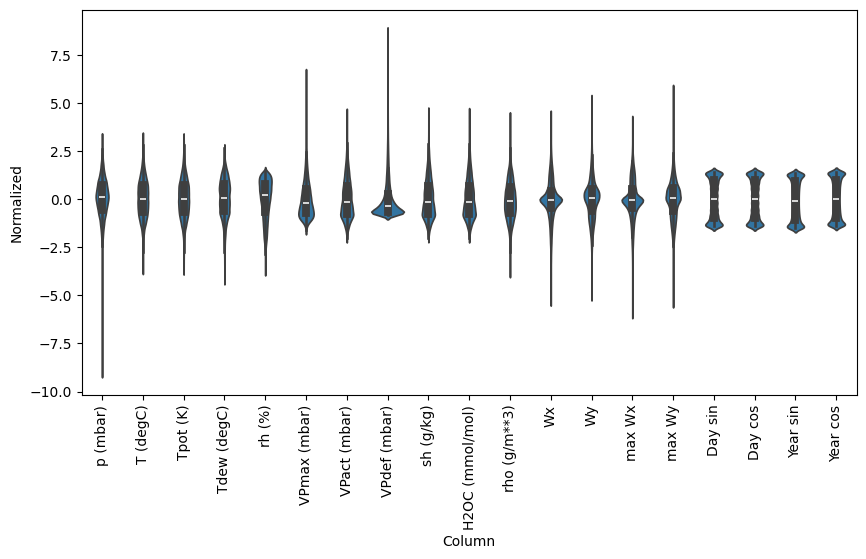

In [165]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(10, 5))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)
plt.show()

### Create Sequences

In [193]:
X_train = df_train.to_numpy()
y_train = df_train['T (degC)'].to_numpy()

X_val = df_val.to_numpy()
y_val = df_val['T (degC)'].to_numpy()

X_test = df_test.to_numpy()
y_test = df_test['T (degC)'].to_numpy()

In [194]:
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape), (X_test.shape, y_test.shape)

(((49052, 19), (49052,)), ((14015, 19), (14015,)), ((7008, 19), (7008,)))

In [195]:
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)

X_val = torch.tensor(X_val, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)

X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

In [214]:
seq_length = 30
pred_length = 1

def sequencer(X, y, seq_length, pred_length):
    X_seq = torch.stack([X[i:i+seq_length] for i in range(len(X) - seq_length - pred_length + 1)])
    y_seq = torch.stack([y[i+seq_length] for i in range(len(y) - seq_length )])

    return X_seq, y_seq

In [219]:
X_train_seq, y_train_seq = sequencer(X_train, y_train, 30, 1)
X_val_seq, y_val_seq = sequencer(X_val, y_val, 30, 1)
X_test_seq, y_test_seq = sequencer(X_test, y_test, 30, 1)

In [221]:
(X_train_seq.shape, y_train_seq.shape),(X_val_seq.shape, y_val_seq.shape), (X_test_seq.shape, y_test_seq.shape)

((torch.Size([49022, 30, 19]), torch.Size([49022])),
 (torch.Size([13985, 30, 19]), torch.Size([13985])),
 (torch.Size([6978, 30, 19]), torch.Size([6978])))

In [230]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_seq, y_train_seq)
val_dataset = TensorDataset(X_val_seq, y_val_seq)
test_dataset = TensorDataset(X_test_seq, y_test_seq)

In [233]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [243]:
y_train_seq[0].numpy()


array(-1.5466937, dtype=float32)

In [254]:
X_train_seq[0,:,1]

tensor([-1.9823, -2.0782, -2.0701, -2.0978, -2.1649, -2.1695, -2.1117, -1.9881,
        -1.9372, -1.8656, -1.9083, -1.8460, -1.7327, -1.7385, -1.7096, -1.6761,
        -1.6726, -1.6588, -1.6426, -1.6183, -1.6068, -1.5721, -1.5686, -1.5767,
        -1.5652, -1.5478, -1.5663, -1.5814, -1.6253, -1.5640])

In [260]:
range(len(X_train_seq[0,:,1]))

range(0, 30)

<Axes: >

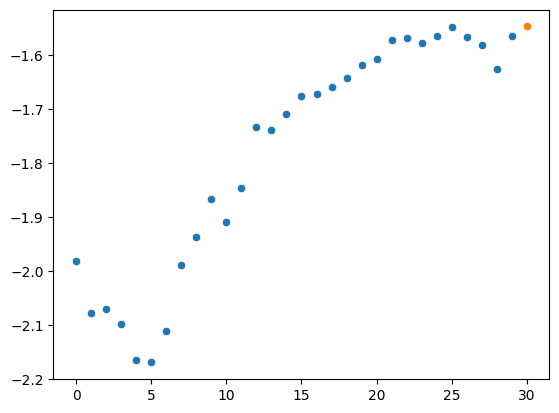

In [265]:
sns.scatterplot(x = range(len(X_train_seq[0,:,1])), y = X_train_seq[0,:,1].numpy())
sns.scatterplot(x = len(X_train_seq[0,:,1]) , y = y_train_seq[0:1].numpy())

## Baseline model

In [278]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

In [279]:
mse_error = MSE(X_train_seq[:,-1,1], y_train_seq)
np.sqrt(mse_error)

0.11820822

In [280]:
mae_error = MAE(X_train_seq[:,-1,1], y_train_seq)
mae_error

0.08295224

<Axes: >

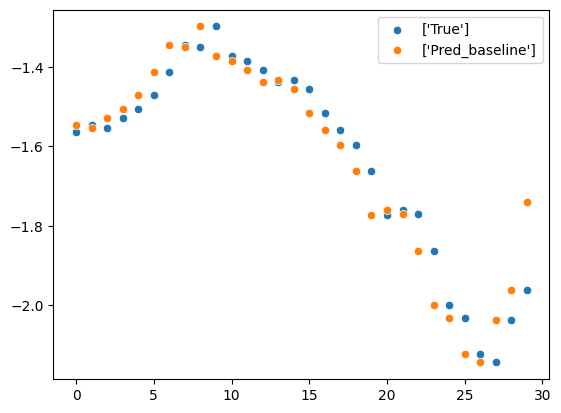

In [284]:
sns.scatterplot(X_train_seq[:30,-1,1], label = ['True'])
sns.scatterplot(y_train_seq[:30], label = ['Pred_baseline'])

<Axes: >

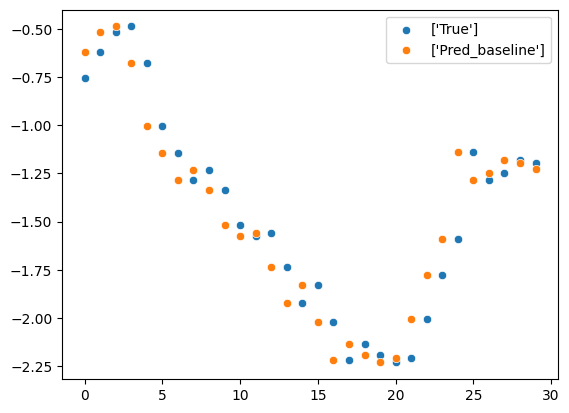

In [285]:
sns.scatterplot(X_train_seq[270:300,-1,1], label = ['True'])
sns.scatterplot(y_train_seq[270:300], label = ['Pred_baseline'])

## MODEL

In [316]:
class model_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, batch_first = True, num_layers = 2, dropout = 0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            dropout=dropout, 
                            batch_first=batch_first)        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, (h,c) = self.lstm(x)
        x = x[:,-1,:]
        out = self.fc(x)

        return out

## Training

In [347]:
torch.mps.empty_cache()

In [348]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [349]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)

In [350]:
input_size = X_train_seq.shape[2]
hidden_size = 128

In [351]:
model = model_LSTM(input_size, hidden_size, batch_first = True, num_layers = 2, dropout = 0.1)

In [352]:
model

model_LSTM(
  (lstm): LSTM(19, 128, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [340]:
for x,y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([32, 30, 19]) torch.Size([32])


In [343]:
preds = model(x)

In [344]:
preds.shape

torch.Size([32, 1])

In [358]:
epochs = 50

model.to(device)

for epoch in range(epochs):
    # Initialize losses for the epoch
    train_loss = 0
    val_loss = 0

    # Training loop
    model.train()
    for x, y in train_loader:
        # Move data to device
        inputs = x.to(device)
        target = y.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        preds = model(inputs)
        loss = criterion(preds, target.view(-1,))  # Adjust the target shape if needed

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        train_loss += loss.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            # Move data to device
            inputs = x.to(device)
            target = y.to(device)

            # Forward pass
            preds = model(inputs)
            loss = criterion(preds, target.view(-1,))  # Adjust the target shape if needed

            # Accumulate validation loss
            val_loss += loss.item()

    # Calculate average losses
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    # Print epoch statistics
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


Epoch 1/50, Train Loss: 0.9889, Val Loss: 0.7867
Epoch 2/50, Train Loss: 0.9889, Val Loss: 0.7867
Epoch 3/50, Train Loss: 0.9889, Val Loss: 0.7867
Epoch 4/50, Train Loss: 0.9889, Val Loss: 0.7867


KeyboardInterrupt: 